## 🏏 IPL Match Winner Prediction Using Machine Learning

### 📦 1. Import Libraries

In [228]:
import pandas as pd     # for data manipulation


### 📊 2. Load and Explore Data

In [229]:
match = pd.read_csv('datasets/matches.csv')
delivery = pd.read_csv('datasets/deliveries.csv')

In [230]:
# delivery.info()
# match.info()

### 🧮 3. Preprocess First Innings Total Score

In [231]:
# delivery.head()

In [232]:
total_score_df = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()     # group by match_id and inning and sum the total runs & store in 'total_runs' column

# Filter for first innings
total_score_df = total_score_df[total_score_df['inning'] == 1]

# Merge the match and total_score_df dataframes by match_id present in total_score_df & id present in match, store in match_df
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')


In [233]:
# total_score_df
# match_df

### 🧹 4. Clean and Normalize Team Names

In [234]:
# Current teams
teams = [
    'Chennai Super Kings',
    'Royal Challengers Bengaluru',
    'Delhi Capitals',
    'Kolkata Knight Riders',
    'Mumbai Indians',
    'Punjab Kings',
    'Rajasthan Royals',
    'Sunrisers Hyderabad',
    'Lucknow Super Giants', 
    'Gujarat Titans'
]

# Fix old team names with new one
team_renames = {
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Kings XI Punjab': 'Punjab Kings',
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad'
}

In [235]:

for old, new in team_renames.items():
    match_df['team1'] = match_df['team1'].str.replace(old, new)
    match_df['team2'] = match_df['team2'].str.replace(old, new)


# Filter for teams in teams list
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

# match_df = match_df[match_df['method'] != 'D/L']        # Remove D/L method (DLS Method)

match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]       # Extract the required fields such as city, winner, total_runs

In [236]:
# match_df

### 🧮 5. Second Innings Match Analysis

In [237]:
delivery_df = match_df.merge(delivery, on="match_id")       # Merge the match_df with delivery

delivery_df = delivery_df[delivery_df['inning'] == 2]       # Filter for second innings, as we have to find while chasing the target
   
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()     # Calculate the current score after each delivery

In [238]:
delivery_df['runs_left'] = (delivery_df['total_runs_x'] - delivery_df['current_score'] + 1).clip(lower=0) # Calculate runs left after each delivery (+1 to win the match)

In [239]:
# delivery_df.columns

In [240]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets_left'] = 10 - wickets

In [241]:
# delivery_df

### 🧮 6. Ball Legality, Overs & Wickets

In [242]:
# delivery_df.extras_type.unique()

In [243]:
# Filter for legal deliveries & store in a new column is_legal
delivery_df['is_legal'] = ~delivery_df['extras_type'].isin(['wides', 'legbyes', 'byes', 'noballs', 'penalty'])      

delivery_df['is_legal'] = delivery_df['is_legal'].fillna(True)  # Replace NaNs with True (if extras_type is NaN, it's a legal delivery)

delivery_df['legal_ball_number'] = delivery_df.groupby(['match_id', 'inning'])['is_legal'].cumsum() # Calculate the legal ball number after each delivery

In [244]:
# delivery_df

### ⚙️ 7. Calculate Run Rates & Match Result

In [245]:
# Calculate overs

delivery_df['overs_done'] = delivery_df['legal_ball_number'] / 6

In [246]:
# Calculate current run rate
# crr = (runs scored / overs played)
delivery_df['crr'] = delivery_df.apply(
    lambda x: x['current_score'] / x['overs_done'] if x['overs_done'] > 0 else 0,
    axis=1
)

In [247]:
# Calculate overs left
delivery_df['overs_left'] = (120 - delivery_df['legal_ball_number']) / 6

# Calculate required run rate
# rrr = (runs needed / overs left)
delivery_df['rrr'] = delivery_df.apply(
    lambda x: x['runs_left'] / x['overs_left'] if x['overs_left'] > 0 else 0,
    axis=1
)

In [248]:
# delivery_df

In [249]:
# Calculate result as boolean (win = 1, loss = 0)
# if batting team in 2nd inning is winner then result = 1 else result = 0

def result(row): 
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result, axis=1)    

In [250]:
# Find the balls left after each legal delivery in 2nd inning

delivery_df['balls_left'] = 120 - delivery_df['legal_ball_number']
delivery_df['balls_left'] = delivery_df.apply(
    lambda x: 120 - x['legal_ball_number'] if x['inning'] == 2 else None,
    axis=1
)

In [251]:
# delivery_df.sample(5)
# delivery_df.columns

### 📄 8. Final Dataset Preparation

In [252]:
# Extract required columns
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr', 'rrr', 'result']]

In [253]:
final_df = final_df.sample(final_df.shape[0])      # shuffle each delivery to avoid overfitting / bias

final_df.dropna(inplace=True)       # removes all rows in final_df that contains at least one NaN value

In [254]:
final_df = final_df[final_df['balls_left'] != 0]  # Filter out all rows where balls_left is not Zero

In [255]:
# final_df

### 🧠 9. Model Training Setup

In [256]:
from sklearn.model_selection import train_test_split        # Split data into training and test sets

In [257]:
X = final_df.iloc[:,:-1] # all rows & all columns except result (last column)
y = final_df.iloc[:,-1] # all rows & last column only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training data & 20% test data, random_state=1 for reproducibility

In [258]:
from sklearn.compose import ColumnTransformer       # apply transformer to specific columns
from sklearn.preprocessing import OneHotEncoder     # convert categorical to binary values

In [259]:
# Convert categorical data to numeric formats
trf = ColumnTransformer([
    ('trf', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'city']) 
    # sparse_output=False to return numpy array
    # drop='first' to avoid dummy variable trap
], remainder='passthrough') # remainder='passthrough' to keep the other columns as it is

### 🤖 10. Model Training & Evaluation

In [260]:
from sklearn.pipeline import Pipeline       # combine transformers and models
from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.ensemble import RandomForestClassifier     # Random Forest

In [261]:
# Create the pipeline

pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))   # Logistic Regression
    # ('step2', RandomForestClassifier())   # Random Forest
])

In [262]:
pipe.fit(X_train,y_train)   # train the model

/home/manas/coding/python/IPL Prediction Model/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

### 📈 11. Metrics of the model

In [263]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay        # for performance metrics

Confusion Matrix:
[[8206 2116]
 [1962 9067]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     10322
           1       0.81      0.82      0.82     11029

    accuracy                           0.81     21351
   macro avg       0.81      0.81      0.81     21351
weighted avg       0.81      0.81      0.81     21351

Accuracy: 0.8090019202847641
Precision: 0.8107842260574085
Recall: 0.8221053586000544
F1 Score: 0.8164055465514136


' \n--> Logistic Regression \n\nConfusion Matrix:\n[[8196 2161]\n [1984 9010]]\n\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       0.81      0.79      0.80     10357\n           1       0.81      0.82      0.81     10994\n\n    accuracy                           0.81     21351\n   macro avg       0.81      0.81      0.81     21351\nweighted avg       0.81      0.81      0.81     21351\n\nAccuracy: 0.805863893962812\nPrecision: 0.8065526810491451\nRecall: 0.8195379297798799\nF1 Score: 0.8129934581547484\n\n--> Random Forest\n\nConfusion Matrix:\n[[10330    27]\n [   18 10976]]\n\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     10357\n           1       1.00      1.00      1.00     10994\n\n    accuracy                           1.00     21351\n   macro avg       1.00      1.00      1.00     21351\nweighted avg       1.00      1.00      1.00     21351\n\nAcc

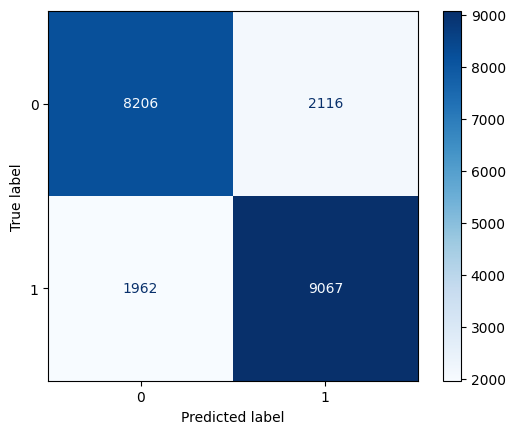

In [264]:
# Predict
y_pred = pipe.predict(X_test)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3. Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# 4. Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


""" 
--> Logistic Regression 

Confusion Matrix:
[[8196 2161]
 [1984 9010]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     10357
           1       0.81      0.82      0.81     10994

    accuracy                           0.81     21351
   macro avg       0.81      0.81      0.81     21351
weighted avg       0.81      0.81      0.81     21351

Accuracy: 0.805863893962812
Precision: 0.8065526810491451
Recall: 0.8195379297798799
F1 Score: 0.8129934581547484

--> Random Forest

Confusion Matrix:
[[10330    27]
 [   18 10976]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10357
           1       1.00      1.00      1.00     10994

    accuracy                           1.00     21351
   macro avg       1.00      1.00      1.00     21351
weighted avg       1.00      1.00      1.00     21351

Accuracy: 0.9978923703807784
Precision: 0.9975461237844224
Recall: 0.9983627433145352
F1 Score: 0.9979542664908851
"""

### 📝 12. Write pkl file

In [265]:
import pickle       # for saving and loading models

In [266]:
# Save the trained model pipeline object 'pipe' to a file named 'pipe.pkl' in binary write mode
pickle.dump(pipe, open('models/logistic_regression.pkl', 'wb'))
# pickle.dump(pipe, open('models/random_forest.pkl', 'wb'))

### 📈 13. Match Progression of a completed match

In [267]:
import numpy as np      # for numerical operations

In [268]:
# Match summary
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

In [269]:
# Function to check match progression of a particular match
def check_match_progression(x_df, match_id, pipe):
    
    match = x_df[x_df['match_id'] == match_id]      # Filter the DataFrame for the given match_id    
    match = match[(match['ball'] == 6)]     # Only consider the last ball of each over (i.e., ball number 6)
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
                     'wickets_left', 'total_runs_x', 'crr', 'rrr']].dropna()    # Select relevant features and remove rows with missing values
    temp_df = temp_df[temp_df['balls_left'] != 0]       # Remove rows where no balls are left (i.e., innings is over)
    result = pipe.predict_proba(temp_df)    # Predict win and loss probabilities using the trained model pipeline

    # Add predicted lose and win probabilities (in percentage) to temp_df
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)
    
    # Add an 'end_of_over' column to indicate over progression (1 to n)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    # Extract target runs from the total_runs_x column (assumes constant for match)
    target = temp_df['total_runs_x'].values[0]

    # Calculate runs scored in each over
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]  # Copy of runs_left after each over
    runs.insert(0, target)  # Insert total target at the start
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)  # Difference gives runs in that over

    # Calculate wickets lost in each over
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]  # Copy of wickets_left
    new_wickets.insert(0, 10)  # Start with 10 wickets
    wickets.append(0)          # Add dummy value to match lengths
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]  # Difference gives wickets lost in that over

    # Print the target for reference
    print("Target-", target)

    # Keep only relevant columns for plotting or further analysis
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]

    return temp_df, target


In [270]:
import matplotlib.pyplot as plt     # for data visualization

In [271]:

def plot_match_progression(temp_df, target):
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))  # 1 row, 3 columns

    # 1️⃣ Plot: Win vs Lose Probability
    axes[0].plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=3, label='Win Probability')
    axes[0].plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=3, label='Lose Probability')
    axes[0].set_title('Win vs Lose Probability')
    axes[0].set_xlabel('End of Over')
    axes[0].set_ylabel('Probability')
    axes[0].legend()
    axes[0].grid(True)

    # 2️⃣ Plot: Runs After Over
    axes[1].bar(temp_df['end_of_over'], temp_df['runs_after_over'], color='skyblue', alpha=0.7)
    axes[1].set_title('Runs After Each Over')
    axes[1].set_xlabel('End of Over')
    axes[1].set_ylabel('Runs')
    axes[1].grid(True)

    # 3️⃣ Plot: Cumulative Wickets Progression
    cumulative_wickets = temp_df['wickets_in_over'].cumsum()
    axes[2].step(temp_df['end_of_over'], cumulative_wickets, where='mid', color='orange', linewidth=3, marker='o')
    axes[2].set_title('Wickets Fallen Over Time')
    axes[2].set_xlabel('End of Over')
    axes[2].set_ylabel('Total Wickets Fallen')
    axes[2].set_ylim(0, 10)  # Since max wickets = 10
    axes[2].grid(True)

    # Overall title
    fig.suptitle(f'Match Progression | Target: {target}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title
    plt.show()


Target- 192


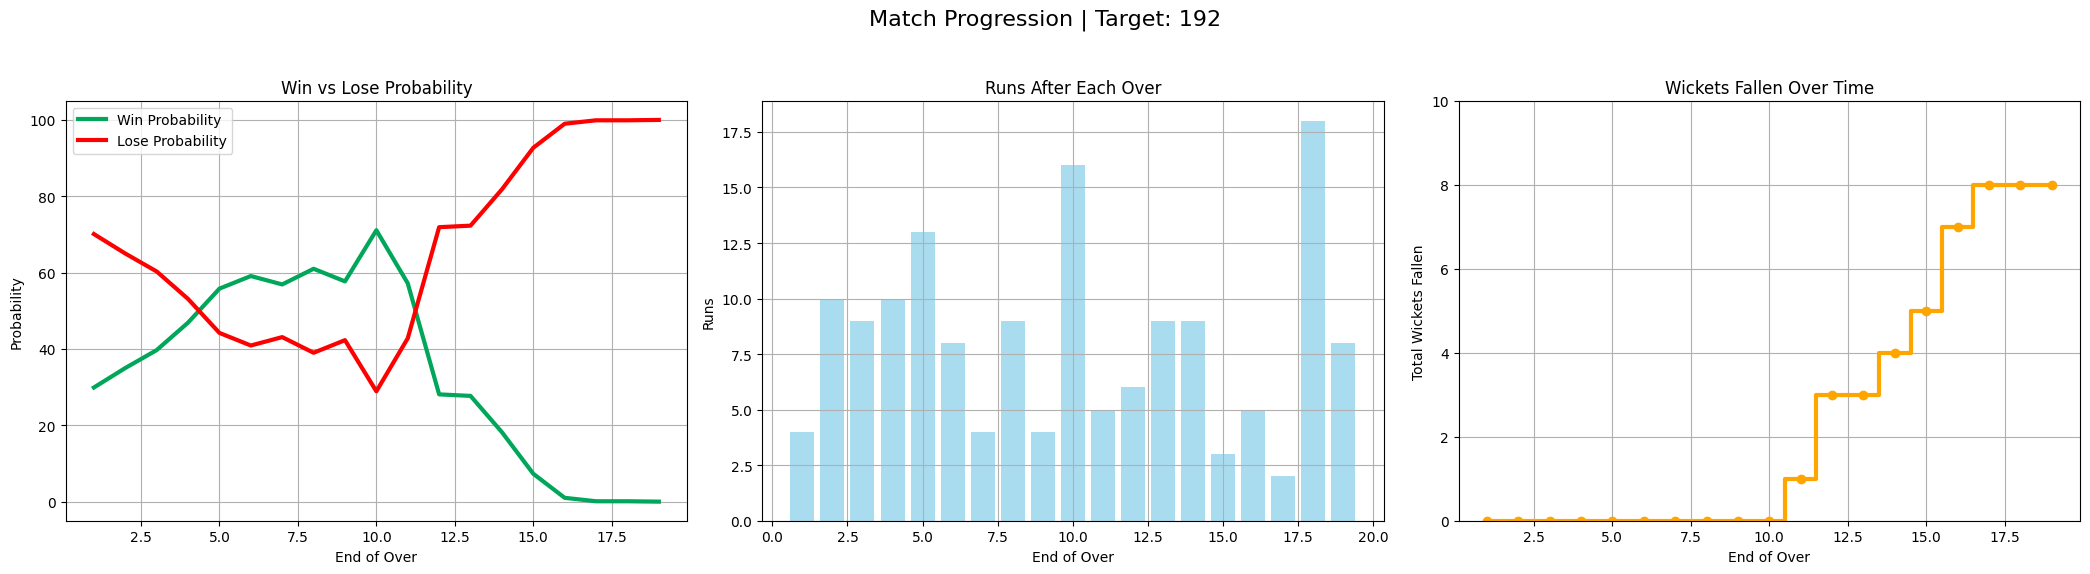

In [272]:
temp_df, target = check_match_progression(delivery_df,1254117,pipe)     # 2021 final match
plot_match_progression(temp_df, target)

### 📍 12. Helper Data: Teams & Cities

In [273]:
cities = delivery_df['city'].unique()
# cities
# teams  # Already defined earlier